# Linear Mapping from VCSN Data to Regional Statistics



In [1]:
from glob import glob
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [3]:
%config InlineBackend.figure_format = 'png'

## Target `NZ_6_regions`

In [4]:
nz_6_regions = ('ENI', 'ESI', 'NNI', 'NSI', 'WNI', 'WSI')
variables = ('RAD', 'RAIN', 'SOILM', 'TMAX', 'TMEAN', 'TMIN', 'WIND')

In [5]:
target_root_dir = '/downscaling/TARGETS/NZ_regions/NZ_6_regions'

def target_filename(variable, region):
    return target_root_dir + f'/{variable}/{region}/TS_NZ_region_{region}_{variable}_3_quantiles_anoms.csv'

In [6]:
df_tmean = {region: pd.read_csv(target_filename('TMEAN', region)) for region in nz_6_regions}
df_tmean['NNI']

time    Tmean_N  cat_3  anomalies
0    1979-03-31  18.278555      3   0.462528
1    1979-04-30  16.794408      2   0.227319
2    1979-05-31  14.695903      2   0.282907
3    1979-06-30  12.093823      2  -0.001099
4    1979-07-31  10.290536      2  -0.061355
..          ...        ...    ...        ...
485  2019-08-31  10.077401      3   0.483058
486  2019-09-30  10.668444      3   0.591605
487  2019-10-31  11.515482      3   0.228983
488  2019-11-30  13.523327      3   0.619542
489  2019-12-31  15.515548      3   0.822261

[490 rows x 4 columns]

Text(0, 0.5, 'Cat_3')

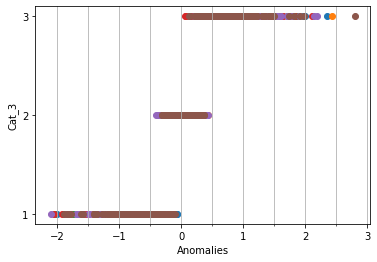

In [7]:
for i, region in enumerate(nz_6_regions):
    plt.scatter(x=df_tmean[region].anomalies, y=df_tmean[region].cat_3)
plt.gca().yaxis.set_major_locator(MultipleLocator(1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.5))
plt.gca().grid(axis='x', which='both')
plt.xlabel(f'Anomalies')
plt.ylabel('Cat_3')


## VCSN data

In [8]:
def vcsn_file(variable):
    return f'/downscaling/VCSN/{variable}/seasonal_anomalies_VCSN_{variable}_N.nc'

In [9]:
ds_vcsn_tmean = xr.open_dataset(vcsn_file('TMEAN'))
ds_vcsn_tmean

<xarray.Dataset>
Dimensions:         (lat: 257, lon: 241, time: 490)
Coordinates:
  * lat             (lat) float32 -47.275 -47.225 -47.175 ... -34.475 -34.425
  * lon             (lon) float32 166.475 166.525 166.575 ... 178.425 178.475
  * time            (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month           (time) int64 ...
Data variables:
    agent           (time, lat, lon) float32 ...
    Tmean_N         (time, lat, lon) float32 ...
    Tmean_N_interp  (time, lat, lon) float64 ...
    mask            (lat, lon) float64 ...

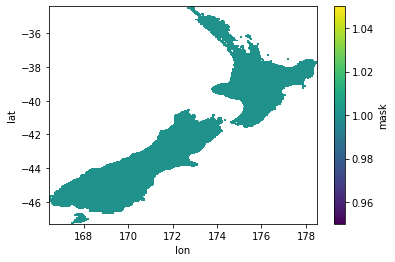

In [10]:
ds_vcsn_tmean.mask.plot()

In [11]:
mask_flat = ds_vcsn_tmean.mask.data.reshape(1, -1)
len_mask = len(mask_flat[~np.isnan(mask_flat)])
print(len_mask)

11491


## Find a linear model that maps the VCSN data to the regional statistics.

This should be identical to the weighted averaging method that calculated the regional data.

In [12]:
Y = np.vstack([df_tmean[r].anomalies for r in nz_6_regions]).transpose()
Y

array([[ 0.62153973, -0.2222545 ,  0.46252752, -0.09332671,  0.31796544,
        -0.40033395],
       [ 0.29905699, -0.20891885,  0.22731853, -0.24917629,  0.24803827,
        -0.11085778],
       [ 0.31465453, -0.47030292,  0.28290679, -0.21565717,  0.42577269,
        -0.20249687],
       ...,
       [ 0.01964536, -0.27818462,  0.22898303, -0.5687997 ,  0.2194081 ,
        -0.41146406],
       [ 0.65195889,  0.40128103,  0.61954223, -0.01359798,  0.65783046,
         0.05970509],
       [ 0.79715889,  0.52809373,  0.82226076, -0.00464012,  0.78460401,
        -0.1159999 ]])

In [13]:
n_instances = len(ds_vcsn_tmean.time)
assert n_instances == Y.shape[0]
print(n_instances)

490


In [14]:
vcsn_flat = ds_vcsn_tmean.Tmean_N.data.reshape(n_instances, -1)
mask = (~np.isnan(mask_flat)).repeat(n_instances, axis=0)
X = vcsn_flat[mask].reshape(n_instances, -1)
print(X.shape)

(490, 11491)


In [15]:
X = torch.from_numpy(X).double()
Y = torch.from_numpy(Y).double()
# X = X.cuda()
# Y = Y.cuda()

### Direct calculation

Suppose there is linear mapping from the fine-grained VCSN data in $X' \in \mathcal{R}^{490\times(11491+1)}$ to the 6-region categorised number in $Y \in \mathcal{R}^{490\times6}$, i.e., $Y = X' \beta$, where $\beta \in \mathcal{R}^{(11491+1)\times6}$ is the weights, the $\beta$ should be able to be directly computed as $\beta = (X'^\top X')^{-1} X'^\top Y$.

In [16]:
design_mat = torch.cat((torch.ones((n_instances, 1), dtype=torch.double),
                        X), dim=1)
moment_mat = design_mat.transpose(0, 1).mm(design_mat)
moment_mat_inv = moment_mat.inverse()
B = moment_mat_inv.mm(design_mat.transpose(0, 1)).mm(Y)

In [17]:
design_mat[0].unsqueeze(0).mm(B)

tensor([[  8.6164,  -2.4541,   3.8902,  -9.5608,   4.1357, -18.9804]],
       dtype=torch.float64)

In [18]:
Y[0]

tensor([ 0.6215, -0.2223,  0.4625, -0.0933,  0.3180, -0.4003],
       dtype=torch.float64)

This bad result of direct calculation is expected, because the number of observations is (much) less than the number of features. Thus the moment matrix $X'^\top X$ is non-invertible.

### Using a linear regression

In [19]:
y = Y.float()
x = X.float()

model = torch.nn.Linear(len_mask, 6)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
n_epochs = 100
for epoch in range(n_epochs):
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat, y)
    loss.backward()
    
    optimizer.step()
    if epoch % int(n_epochs / 10) == 0:
        print(f'Epoch {epoch}: loss={loss}')

Epoch 0: loss=0.6654013991355896
Epoch 10: loss=0.03150629997253418
Epoch 20: loss=0.019628724083304405
Epoch 30: loss=0.015209514647722244
Epoch 40: loss=0.012652535922825336
Epoch 50: loss=0.010905824601650238
Epoch 60: loss=0.009610543958842754
Epoch 70: loss=0.008601350709795952
Epoch 80: loss=0.007788342889398336
Epoch 90: loss=0.0071173072792589664


In [20]:
model(x[0])

tensor([ 0.5343, -0.2069,  0.4120, -0.0515,  0.3389, -0.4271],
       grad_fn=<AddBackward0>)

In [21]:
y[0]

tensor([ 0.6215, -0.2223,  0.4625, -0.0933,  0.3180, -0.4003])

## Compute the averages using the regional masks.

In [22]:
ds_regional_masks = xr.open_dataset('../dataset/NZ_6_regions_mask.nc')

In [23]:
ds_regional_masks

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241)
Coordinates:
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
Data variables:
    region   (lat, lon) float64 ...
    NNI      (lat, lon) float64 ...
    WNI      (lat, lon) float64 ...
    ENI      (lat, lon) float64 ...
    NSI      (lat, lon) float64 ...
    WSI      (lat, lon) float64 ...
    ESI      (lat, lon) float64 ...

In [24]:
vcsn_nni = ds_vcsn_tmean.Tmean_N.interp_like(ds_regional_masks, method='nearest') * ds_regional_masks.NNI

In [25]:
vcsn_nni

<xarray.DataArray (time: 490, lat: 257, lon: 241)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5

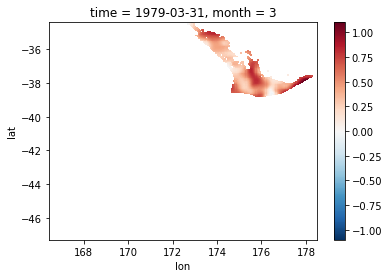

In [26]:
vcsn_nni[0].plot()

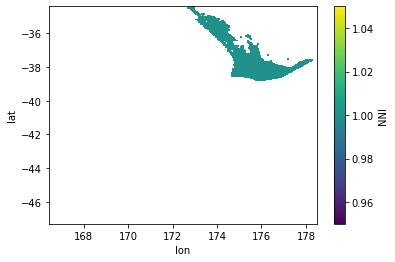

In [27]:
ds_regional_masks.NNI.plot()

In [28]:
print(np.logical_not(np.isnan(vcsn_nni[0])).astype(int).sum().data,
      np.logical_not(np.isnan(ds_regional_masks.NNI)).astype(int).sum().data,
     )

1972 2004


In [29]:
vcsn_nni.mean(dim=('lat', 'lon'))

<xarray.DataArray (time: 490)>
array([ 4.57557022e-01,  2.22527449e-01,  2.78560672e-01, -1.19035414e-03,
       -6.06557710e-02,  7.23962398e-02, -1.96582105e-01, -7.73133188e-02,
        1.15901408e-01, -2.76949169e-02, -3.85601096e-02, -3.03575429e-01,
       -5.41153692e-01, -8.63152284e-01, -9.02163662e-01, -6.59713432e-01,
       -5.35523698e-01, -6.88499735e-01, -4.88627506e-01, -3.97193052e-02,
        2.62384567e-02, -2.45003464e-01, -3.69467288e-03,  3.82625024e-01,
        1.11408698e+00,  9.64548057e-01,  6.53659601e-01,  3.90654470e-01,
        3.59980815e-02, -3.76507077e-02, -5.80406380e-01, -6.05864032e-01,
       -3.67466532e-01,  2.43810951e-01,  3.59156525e-01,  5.05141999e-01,
       -8.28689349e-02, -5.43059407e-01, -9.52103074e-01, -1.24194501e+00,
       -1.09700216e+00, -1.07989733e+00, -8.48033891e-01, -9.77420745e-01,
       -5.85248717e-01, -7.61648366e-01, -8.02339182e-01, -1.40876957e+00,
       -8.48719481e-01, -2.71192629e-01, -1.24133507e-01, -3.72045834e-01,
       -8.90802067e-01, -7.06369982e-01, -5.11480285e-01,  2.18541462e-01,
        1.73447056e-01, -2.71271612e-01, -1.06597424e+00, -1.20344410e+00,
       -6.46258305e-01, -2.12198939e-01, -2.10757061e-01, -3.19561238e-01,
        6.45995141e-02,  5.83924127e-01,  2.73541116e-01, -1.10255595e-01,
        1.15874972e-01,  8.28680268e-01,  1.24935611e+00,  5.38133449e-01,
       -9.89347162e-02, -3.60125393e-01, -4.89965859e-01, -1.22507131e-01,
        2.99651051e-01,  4.15506122e-01,  1.95081417e-01, -3.31494308e-01,
...
        2.36248669e-01,  5.61061133e-01,  7.07481142e-01,  8.23384261e-01,
        8.01355581e-01,  6.69688451e-01,  2.04553808e-01, -2.49108103e-01,
       -4.00455479e-01,  4.34536495e-01,  4.29685678e-01,  1.07313545e+00,
        5.62523488e-01,  5.81751587e-01,  2.26027694e-01,  2.60371782e-01,
        1.11427076e-02, -1.22407578e-01,  3.64949654e-01,  5.05857031e-01,
        6.92114074e-01,  4.62794703e-01,  5.76536246e-01,  4.13456776e-01,
        4.33841024e-02,  5.91601098e-02, -2.77739127e-01, -2.64472874e-02,
        2.00856869e-02,  2.23225514e-01,  5.75872611e-01,  1.09190025e+00,
        1.54572256e+00,  1.40983233e+00,  1.56364601e+00,  1.48062066e+00,
        1.38827769e+00,  5.93525935e-01,  5.31805873e-01,  4.57759102e-01,
        5.71681486e-01,  6.63384958e-02, -3.03494996e-01, -2.19623321e-01,
        3.11380336e-01,  1.03485924e+00,  8.06895641e-01,  4.98899788e-01,
        1.09372537e-01,  5.88583680e-01,  6.22884014e-01,  8.53062254e-01,
        6.62846898e-01,  1.12771772e+00,  1.77527365e+00,  1.86505491e+00,
        1.70346494e+00,  1.04109664e+00,  8.30635346e-01,  4.54573330e-01,
        3.62838198e-01,  4.18748669e-01,  3.31820132e-01,  1.94410201e-01,
        8.86909184e-02,  4.24379819e-01,  1.05131425e+00,  1.11957688e+00,
        1.31254836e+00,  5.74614678e-01,  7.26776546e-01,  1.19315746e-01,
        6.73591641e-01,  4.82634404e-01,  5.90812358e-01,  2.30155465e-01,
        6.20365846e-01,  8.24599926e-01])
Coordinates:
  * time     (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 2 3 4 5 6 7 8 9 10 11 12

In [30]:
errors = vcsn_nni.mean(dim=('lat', 'lon')) - df_tmean['NNI'].anomalies

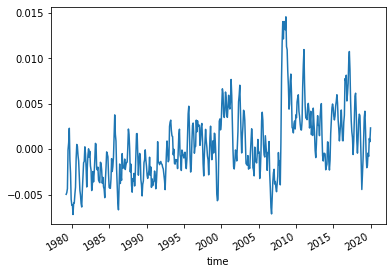

In [31]:
errors.plot()

In [41]:
regional_means = {region: (ds_vcsn_tmean.Tmean_N.interp_like(ds_regional_masks, method='nearest')
                           * ds_regional_masks.region).mean(dim=('lat', 'lon'))
                  for region in nz_6_regions
                 }

In [40]:
thresholds = pd.read_csv('/Scratch/dh146/niwa-downscaling/dataset/Climatological_quantiles_3_cat_TMEAN.csv',
                        header=2, index_col=0)
thresholds.columns = [f'{region}_{split}' for split in ('Q33', 'Q66')
                      for region in ('NNI', 'ENI', 'WNI', 'NSI', 'WSI', 'ESI')]
thresholds

NNI_Q33    ENI_Q33    WNI_Q33    NSI_Q33    WSI_Q33    ESI_Q33  \
season                                                                     
1       16.192205  16.711533  14.558706  15.362723  14.022534  14.757577   
2       17.571612  18.161279  15.981903  16.667819  15.606067  16.212981   
3       17.602604  18.059826  15.896412  16.301075  15.457978  15.979070   
4       16.337604  16.868952  14.347398  14.918828  13.997594  14.607034   
5       14.278205  14.800033  12.146405  12.752033  11.807512  12.544035   
6       11.937089  12.446445   9.975187  10.346840   9.660703  10.105945   
7       10.140742  10.559623   8.026645   8.555372   7.794877   8.388257   
8        9.344997   9.853737   7.247226   7.791770   7.057408   7.653609   
9        9.839720  10.300074   7.922671   8.322755   7.723394   8.141653   
10      11.094165  11.481375   9.244114   9.713870   8.924829   9.452946   
11      12.674836  13.070894  10.943933  11.396907  10.612022  11.094864   
12      14.446111  14.946266  12.860775  13.555343  12.316661  13.091015   

          NNI_Q66    ENI_Q66    WNI_Q66    NSI_Q66    WSI_Q66    ESI_Q66  
season                                                                    
1       12.448537  12.884851  11.025878  11.590436  12.590779  13.460794  
2       13.717394  14.390106  12.308727  12.847326  13.961950  14.570645  
3       13.651205  14.092328  12.135498  12.709280  13.676743  14.276748  
4       12.342522  12.731987  10.541552  11.236765  11.905881  12.646973  
5        9.936486  10.498057   8.150917   8.723350   9.445587  10.051895  
6        7.485466   7.804372   5.610571   6.098422   6.795469   7.332978  
7        5.281846   5.965562   3.441573   3.955721   4.597933   5.222299  
8        4.505057   5.402480   2.709681   3.470722   3.970116   4.473995  
9        5.378278   5.961090   3.693716   4.301107   5.058928   5.548815  
10       6.941567   7.318055   5.593627   5.853764   6.972609   7.469444  
11       8.624462   9.047063   7.385151   7.846476   8.933834   9.485311  
12      10.495509  11.052956   9.198244   9.840042  10.838836  11.383775

In [47]:
regional_lt_q33 = {region: regional_means[region] < thresholds[f'{region}_Q33'][regional_means[region].month]
                  for region in nz_6_regions}

In [49]:
regional_lt_q66 = {region: regional_means[region] < thresholds[f'{region}_Q66'][regional_means[region].month]
                  for region in nz_6_regions}

In [51]:
regional_means['NNI']

<xarray.DataArray (time: 490)>
array([-6.07890432e-01, -2.75849217e-01, -5.62488844e-01, -5.72029294e-01,
        1.93022255e-01,  1.84933321e-01, -4.92050251e-01, -1.27509542e+00,
        5.77558879e-01,  1.77607164e-01,  3.30130382e-02, -1.97758843e+00,
       -2.58313347e+00, -2.19143477e+00, -9.07353619e-01, -4.68183908e-01,
       -9.11709370e-01, -1.17284597e+00, -2.27723158e-01,  1.29181318e+00,
       -4.45445922e-01, -3.63943704e-01, -4.16063956e-01,  1.42038946e+00,
        2.03938282e+00,  2.32648841e+00,  1.32131437e+00,  5.43298636e-01,
       -5.58728781e-01, -1.35610901e+00, -2.53353147e+00, -2.15169658e+00,
        1.60860908e-01,  2.34889279e+00,  1.52334691e+00,  1.24187900e+00,
        4.29275227e-01, -2.15420043e-01, -7.95358925e-01, -2.52544345e+00,
       -2.31894787e+00, -1.94652694e+00, -1.17058102e+00, -1.75453409e+00,
       -2.06539550e+00, -3.27119321e+00, -3.55554333e+00, -4.84111267e+00,
       -3.84290432e+00, -2.43770852e+00, -2.01422246e+00, -1.97125906e+00,
       -1.77629355e+00, -1.00004687e+00, -6.83504680e-01,  2.26655910e-01,
        6.01041955e-02, -1.04680475e+00, -3.31473829e+00, -3.61857832e+00,
       -1.30867003e+00,  7.56806819e-01, -3.43412597e-01, -1.81596764e-01,
        4.27767907e-01,  2.41255845e+00,  1.00580059e+00,  1.58454424e-01,
        6.90859474e-01,  1.56716099e+00,  2.40051105e+00,  8.68593543e-01,
        1.40843355e-02,  4.92150461e-02, -2.37012481e-01,  6.55418115e-01,
        8.38430627e-01,  1.14840939e+00,  8.12784665e-01, -2.94460949e-01,
...
        2.33593218e+00,  3.59552967e+00,  3.68846488e+00,  2.09337053e+00,
        1.72094683e+00,  1.94636411e+00,  1.46402757e-01, -1.18086709e+00,
       -1.68977766e+00,  7.35446014e-01,  1.35797824e+00,  3.07276446e+00,
        2.77697570e+00,  2.01141492e+00,  6.58934465e-01,  1.56354120e-02,
       -1.01047490e+00, -4.45601783e-01,  1.13862542e+00,  1.86337333e+00,
        1.42457372e+00,  7.46211360e-01,  1.35643027e+00,  1.10385581e+00,
        5.43558359e-01, -1.08984783e-01, -1.29809349e+00, -8.62322915e-01,
       -7.83189542e-01,  1.06320814e-01, -2.56434405e-01,  2.12541012e+00,
        3.15590010e+00,  4.27636133e+00,  3.65398259e+00,  4.35926696e+00,
        4.02319330e+00,  2.11037110e+00,  1.36030754e+00,  9.45902946e-01,
        1.20144774e+00, -1.25982444e-01, -1.94263333e+00, -2.16096886e+00,
       -1.43662045e+00,  9.35492673e-01,  8.11998611e-01,  7.77435217e-01,
       -6.80239895e-02,  1.42037887e+00,  1.36287177e+00,  2.45999497e+00,
        2.72178302e+00,  4.69579048e+00,  7.37960221e+00,  5.68304782e+00,
        4.19388248e+00,  3.36022851e-01,  3.29471048e-01, -5.89700761e-01,
        1.18655118e+00,  1.89738177e+00,  2.03809934e+00,  8.19719293e-01,
        4.07030209e-01,  1.54836668e+00,  2.94574980e+00,  2.60336843e+00,
        3.58255554e+00,  1.77889227e+00,  3.67359283e+00,  1.70497040e+00,
        3.84960220e+00,  1.97756576e+00,  1.38201196e+00, -9.90812442e-01,
        5.97880795e-01,  4.67074519e-01])
Coordinates:
  * time     (time) datetime64[ns] 1979-03-31 1979-04-30 ... 2019-12-31
    month    (time) int64 3 4 5 6 7 8 9 10 11 12 1 ... 2 3 4 5 6 7 8 9 10 11 12